In [108]:
import torch
import numpy as np
from torch import Tensor
from numpy import ndarray as array
from helper import to_2d, tensor_size

from typing import Callable, Dict, Tuple, List, NamedTuple

# Boston data

In [109]:
from sklearn.datasets import load_boston

In [110]:
boston = load_boston()

In [111]:
data = boston.data
target = boston.target
features = boston.feature_names

## SciKit Learn Linear Regression

### Data prep

In [112]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

In [113]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)

In [114]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.7197224944944625

In [115]:
import numpy as np
np.round(lr.coef_, 2)

array([-1.01,  0.71,  0.28,  0.71, -2.21,  2.37,  0.72, -2.66,  2.63,
       -1.82, -2.33,  0.86, -4.2 ])

### Manual linear regression

In [137]:
X_train, X_test, y_train, y_test = Tensor(X_train), Tensor(X_test), Tensor(y_train), Tensor(y_test)

In [138]:
def permute_data(X, y):
    perm = torch.randperm(X.shape[0])
    return X[perm], y[perm]

In [139]:
def loss_gradients(forward_info) -> Tensor:
    
    dLdP = -(forward_info['y'] - forward_info['P'])
    
    dPdN = torch.ones_like(forward_info['N'])
    
    dLdN = dLdP * dPdN
    
    dNdW = forward_info['X'].transpose(0, 1)

    dLdW = torch.mm(dNdW, dLdN)
    
    dPdB = torch.ones_like(forward_info['B'])
    
    dLdB = dLdP * dPdB
    
    return dLdW, dLdB

In [140]:
from typing import Iterator
Batch = Tuple[Tensor, Tensor]

def generate_batch(X: Tensor, 
                   y: Tensor,
                   start: int = 0,
                   batch_size: int = 10) -> Iterator[Batch]:
    
    assert (X.dim() == 2) and (y.dim() == 2), \
    "X and Y must be 2 dimensional"

    if start+batch_size > X.shape[0]:
        batch_size = X.shape[0] - start
    
    X_batch, y_batch = X[start:start+batch_size], y[start:start+batch_size]
    
    return X_batch, y_batch

In [141]:
def forward_loss(X: Tensor,
                 y: Tensor,
                 W: Tensor,
                 B: Tensor) -> Tuple[Dict[str, Tensor], float]:

    # For the matrix multiplication to work,
    assert X.shape[1] == W.shape[0], \
    "Dimensions of betas and feature size do not match"

    N = torch.mm(X, W)

    P = torch.add(N, B.item())

    loss = torch.sum(torch.pow(y - P, 2)).item()

    forward_info: Dict[str, Tensor] = {}
    forward_info['X'] = X
    forward_info['W'] = W
    forward_info['B'] = B
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y

    return forward_info, loss

In [142]:
def train(X: Tensor, 
          y: Tensor, 
          n_iter: int = 1000,
          learning_rate: float = 0.01,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          seed: int = 1) -> None:

    if seed:
        torch.manual_seed(seed)
    y = to_2d(y, "col")
    start = 0

    # Initialize weights
    W = torch.empty(X.shape[1], 1).uniform_(-1, 1)
    B = torch.empty(1, 1).uniform_(-1, 1)

    # Permute data
    X, y = permute_data(X, y)
    
    if return_losses:
        losses = []

    for i in range(n_iter):

        if start >= X.shape[0]:
            X, y = permute_data(X, y)
            start = 0
        
        X_batch, y_batch = generate_batch(X, y, start, batch_size)

        start += batch_size
    
        forward_info, loss = forward_loss(X_batch, y_batch, W, B)

        if return_losses:
            losses.append(loss)

        dLdW, dLdB = loss_gradients(forward_info)
        W -= learning_rate * dLdW
        B -= learning_rate * torch.sum(dLdB)
    
    if return_weights:
        weights: Dict[str, Tensor] = {}
        weights['W'] = W
        weights['B'] = B
        return losses, weights
    
    return None

In [143]:
train_info = train(X_train, y_train, 
                   learning_rate = 0.001,
                   batch_size=19, 
                   return_losses=True, 
                   return_weights=True, 
                   seed=80718)
losses = train_info[0]
weights = train_info[1]

In [144]:
def predict(X: Tensor, 
            y: Tensor, 
            weights: Dict[str, Tensor]):
    
    N = torch.mm(X, weights['W'])

    return torch.add(N, weights['B'].item())

In [145]:
preds = predict(X_test, y_test, weights)

In [146]:
from sklearn.metrics import r2_score
r2_score(preds, y_test)

0.580529526332294

### Tuning learning rate

In [150]:
def r2_score_2(learning_rate: float = 0.01, 
             n_iter: int = 1000) -> float:
    train_info = train(X_train, y_train, 
                       learning_rate=learning_rate,
                       batch_size=23, 
                       n_iter=n_iter,
                       return_losses=True, 
                       return_weights=True, 
                       seed=80718)

    losses = train_info[0]
    weights = train_info[1]

    preds = predict(X_test, y_test, weights)
    
    return r2_score(preds, y_test)

In [151]:
lrs = np.geomspace(0.01, 0.00001, 50)

In [152]:
r2s = [r2_score_2(float(lr), 10000) for lr in lrs]

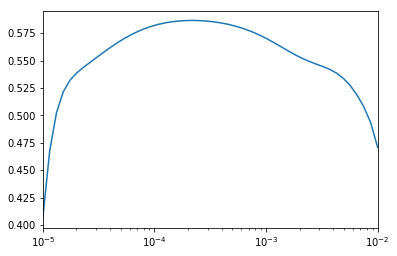

In [153]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.xlim(lrs[-1], lrs[0])
plt.semilogx(lrs, r2s);

### Analyzing best model

In [157]:
train_info = train(X_train, y_train, 
                   learning_rate=0.0002,
                   batch_size=23, 
                   n_iter=10000,
                   return_losses=True, 
                   return_weights=True, 
                   seed=80718)

losses = train_info[0]
weights = train_info[1]

preds = predict(X_test, y_test, weights)

In [158]:
weights['W']

tensor([[-1.0014],
        [ 0.6908],
        [ 0.2472],
        [ 0.7149],
        [-2.2061],
        [ 2.3760],
        [ 0.7110],
        [-2.6672],
        [ 2.5395],
        [-1.7179],
        [-2.3258],
        [ 0.8528],
        [-4.1907]])

In [159]:
lr.coef_

array([-1.00677299,  0.70553407,  0.27897821,  0.70964421, -2.21195566,
        2.37317966,  0.7164624 , -2.66326995,  2.62957833, -1.81593133,
       -2.32931902,  0.85741777, -4.19602686])

In [160]:
weights['B']

tensor([[22.6193]])

In [161]:
lr.intercept_

22.61845081746217

## Plotting loss

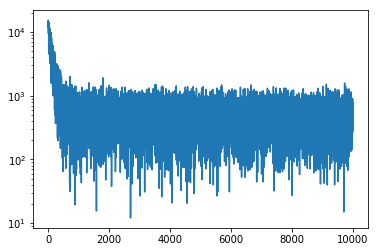

In [162]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.semilogy(list(range(10000)), losses); 

# Logistic regression

### Helpers

In [163]:
def sigmoid(x: Tensor, 
            deriv: bool=False) -> Tensor:
    if deriv:
        return sigmoid(x) * (1 - sigmoid(x))
    else:
        return 1 / (1 + torch.exp(-1.0 * x))

In [164]:
def softmax(x: Tensor) -> Tensor:

    assert x.dim() == 2, \
    "Expect Tensor with shape (batch_size, num_classes), instead " + \
    "x has shape {0}".format(x.shape)
    
    def _softmax_row(row: Tensor) -> Tensor:
        
        assert row.dim() == 1, \
        "'row' should indeed be a row, instead it has shape" \
        .format(row.shape)
        
        exp_obs = torch.exp(row)
        sum_exp_obs = exp_obs.sum().item()
        softmax_obs = exp_obs / sum_exp_obs
        
        return softmax_obs

    output_rows = []
    for obs in range(x.shape[0]):
        output_row = to_2d(_softmax_row(x[obs]), "row")
        output_rows.append(output_row)
        
    return torch.cat(output_rows)
    

In [165]:
softmax(Tensor([[10, 8, 6, 4, 2]]))

tensor([[0.8647, 0.1170, 0.0158, 0.0021, 0.0003]])

## Sklearn logistic regression

In [250]:
from sklearn.datasets import load_breast_cancer
breast_cancer = load_breast_cancer()
data = breast_cancer.data
target = breast_cancer.target
features = breast_cancer.feature_names

### Data prep

In [251]:
s = StandardScaler()
data = s.fit_transform(data)

In [252]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                    test_size=0.3, 
                                                    random_state=80718,
                                                    stratify=target)

In [253]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [254]:
logr = LogisticRegression(C=10e9)
logr.fit(X_train, y_train)
logr.score(X_test, y_test)

0.9766081871345029

### Hand rolled logistic regression

#### Data preprocessing

In [255]:
def predictions_to_2d(predictions: Tensor) -> Tensor:
    
    assert predictions.shape[1] == 1, \
    "Expected a column for predictions, got shape: {}".format(predictions.shape)
    
    inverse_predictions = 1 - predictions
    
    return torch.cat([predictions, inverse_predictions], dim=1)

In [256]:
X_train, X_test, y_train, y_test = Tensor(X_train), Tensor(X_test), Tensor(y_train), Tensor(y_test)

In [257]:
y_train, y_test = predictions_to_2d(to_2d(y_train, "col")), predictions_to_2d(to_2d(y_test, "col"))

### Modeling functions

In [258]:
def forward_logistic(X: Tensor,
                     y: Tensor,
                     W: Tensor, 
                     B: Tensor) -> Tensor:
    
    # For the matrix multiplication to work, 
#     assert observations.shape[1] == betas.shape[0], \
#     "Dimensions of betas and feature size do not match"
    
    N = torch.mm(X, W)
    
    O = torch.add(N, B.item())
    
    P = sigmoid(O)

    P = predictions_to_2d(P)
    
    L = cross_entropy(softmax(P), y)
    
    forward_info: Dict[str, Tensor] = {}
    forward_info['X'] = X
    forward_info['W'] = W
    forward_info['B'] = B
    forward_info['N'] = N
    forward_info['O'] = O
    forward_info['P'] = P  
    forward_info['y'] = y 
    
    return forward_info, L.sum().item() / X.shape[0]

In [259]:
def cross_entropy(predictions: Tensor, 
                  actual: Tensor) -> Tensor:
    
    assert predictions.shape == actual.shape, \
    "Prediction and actual must have same shape"
    
    return -1.0 * actual * torch.log(predictions) - (1.0 - actual) * torch.log(1 - predictions)

In [260]:
def loss_bce_softmax_deriv(predictions: Tensor, 
                           actual: Tensor) -> Tensor:

    assert predictions.shape == actual.shape, \
    "Prediction and actual must have same shape"

    return to_2d((predictions - actual)[:, 0], "col")

In [261]:
def loss_gradients_logistic(forward_info: Dict[str, Tensor]) -> Tensor:

#     import pdb; pdb.set_trace()
    dLdP = loss_bce_softmax_deriv(forward_info['P'], 
                                  forward_info['y'])
    
    dPdO = sigmoid(forward_info['O'], deriv=True)
    
    dLdO = dLdP * dPdO
    
    dOdB = torch.ones_like(forward_info['B'])
    
    dLdB = dLdO * dOdB
    
    dOdN = torch.ones_like(forward_info['N'])
    
    dLdN = dLdO * dOdN
    
    dNdW = forward_info['X'].transpose(0, 1)

    dLdW = dNdW.mm(dLdN)
    
    return dLdW, dLdB

In [262]:
def train(X: Tensor, 
          y: Tensor, 
          n_iter: int = 1000,
          learning_rate: float = 0.01,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          seed: int = 1) -> None:

    if seed:
        torch.manual_seed(seed)
    start = 0

    # Initialize weights
    W = torch.empty(X.shape[1], 1).uniform_(-1, 1)
    B = torch.empty(1, 1).uniform_(-1, 1)

    # Permute data
    X, y = permute_data(X, y)
    
    if return_losses:
        losses = []

    for i in range(n_iter):

        if start >= X.shape[0]:
            X, y = permute_data(X, y)
            start = 0
        
        X_batch, y_batch = generate_batch(X, y, start, batch_size)

        start += batch_size
    
        forward_info, loss = forward_logistic(X_batch, y_batch, W, B)

        if return_losses:
            losses.append(loss)

        dLdW, dLdB = loss_gradients_logistic(forward_info)
        W -= learning_rate * dLdW
        B -= learning_rate * torch.sum(dLdB)
    
    if return_weights:
        weights: Dict[str, Tensor] = {}
        weights['W'] = W
        weights['B'] = B
        return losses, weights
    
    return None

In [263]:
train_info = train(X_train, y_train, 
                   learning_rate = 0.001,
                   batch_size=20, 
                   return_losses=True, 
                   return_weights=True, 
                   seed=80718)
losses = train_info[0]
weights = train_info[1]

In [264]:
def logistic_predict(X: Tensor, 
                     y: Tensor, 
                     weights: Dict[str, Tensor]):
    
    N = torch.mm(X, weights['W'])
    
    O = torch.add(N, weights['B'].item())
    
    P = sigmoid(O)

    return P >= 0.5

### Prediction

In [265]:
preds = logistic_predict(X_test, y_test, weights)[:, 0]

In [266]:
accuracy_score(preds, y_test[:, 0])

0.9649122807017544

In [267]:
def accuracy_score_lr(learning_rate: float = 0.01, 
                      n_iter: int = 1000) -> float:
    train_info = train(X_train, y_train, 
                       learning_rate=learning_rate,
                       batch_size=20, 
                       n_iter=n_iter,
                       return_losses=True, 
                       return_weights=True, 
                       seed=80718)

    losses = train_info[0]
    weights = train_info[1]

    preds = logistic_predict(X_test, y_test, weights)[:, 0]
    
    return accuracy_score(preds, y_test[:, 0])

In [268]:
iters = np.geomspace(10, 10000, 50)

In [279]:
accs = [accuracy_score_lr(0.01, int(it)) for it in iters]

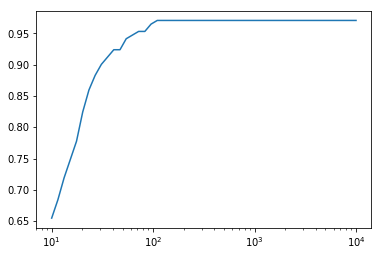

In [280]:
import matplotlib.pyplot as plt
%matplotlib inline

# plt.xlim(iters[-1], lrs[0])
plt.semilogx(iters, accs);

In [281]:
lrs = np.geomspace(0.1, 0.00001, 50)

In [282]:
accs_lr = [accuracy_score_lr(float(lr), 1000) for lr in lrs]

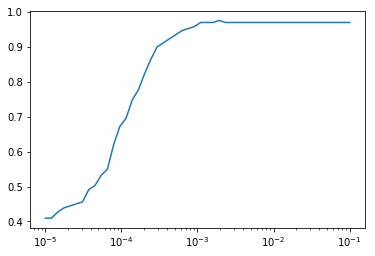

In [283]:
import matplotlib.pyplot as plt
%matplotlib inline

# plt.xlim(iters[-1], lrs[0])
plt.semilogx(lrs, accs_lr);

### Analyzing best model

In [284]:
train_info = train(X_train, y_train, 
                   learning_rate=0.01,
                   batch_size=20, 
                   n_iter=1000,
                   return_losses=True, 
                   return_weights=True, 
                   seed=80718)

losses = train_info[0]
weights = train_info[1]

preds = logistic_predict(X_test, y_test, weights)[:, 0]

In [285]:
logr.coef_

array([[  1.28519871,   1.16626383,   9.02819983,  20.55925949,
         -9.21343284,  31.75684994, -37.39353638, -24.77221482,
          5.73535289,  -3.00627234, -22.16539346,  11.94608271,
          5.3694067 , -45.12241804,  -8.85606629, -19.76363325,
          5.45690084,  -2.21020538,  17.47779262,  42.71134151,
        -38.82027892, -27.27501981, -24.71628495, -24.88493576,
         -6.96910588,  30.89093275,  -0.5549467 , -17.51174391,
        -23.00002361, -34.61004616]])

In [286]:
weights['W']

tensor([[-0.1910],
        [-0.6998],
        [-1.0452],
        [-0.8638],
        [-0.1794],
        [ 0.3026],
        [-0.2207],
        [-0.4614],
        [ 0.1083],
        [-0.0745],
        [-0.7850],
        [ 0.6330],
        [-1.0504],
        [-0.1120],
        [-0.0739],
        [-0.2744],
        [ 0.2449],
        [-0.2531],
        [ 0.4973],
        [ 0.6589],
        [ 0.0187],
        [-0.7388],
        [ 0.3013],
        [-1.4921],
        [-1.0442],
        [ 0.1209],
        [-0.9671],
        [-0.1102],
        [-0.6200],
        [ 0.1354]])

The point of this exercise was just to sanity check that our math was correct; that these operations, which we argued through a bunch of equations would lead to us solving a logistic regression problem, actually does lead to that.